<a href="https://colab.research.google.com/github/teamsimcoemmai/mmai894/blob/main/Final%20Project/Xception_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import matplotlib.pyplot as plt
# import os

from tensorflow import keras
from keras import Input
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, AvgPool2D
from keras.preprocessing import image,image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.applications import Xception

In [ ]:
# Image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=5,
                                   zoom_range=1.1,    
                                   brightness_range=[0,0.2],
                                   )

# Get train, val and tets data
train_data = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Simcoe/894/Car dataset/new/train_set',
                                                target_size=(224,224),
                                                batch_size=32,
                                                seed=42,
                                                class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_data = val_datagen.flow_from_directory('/content/gdrive/MyDrive/Simcoe/894/Car dataset/new/val_set',
                                            target_size=(224,224),
                                            batch_size=32,
                                            seed=42,
                                            class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_data = val_datagen.flow_from_directory('/content/gdrive/MyDrive/Simcoe/894/Car dataset/new/test_set',
                                            target_size=(224,224),
                                            batch_size=32,
                                            seed=42,
                                            class_mode='categorical',
                                            shuffle=False)

Found 11330 images belonging to 196 classes.
Found 2428 images belonging to 196 classes.
Found 2427 images belonging to 196 classes.


In [ ]:
#load the Xception model
img_size=224
#load pre trained Xception model
base_model= Xception(weights='imagenet',include_top= False,input_shape=(img_size,img_size,3))
base_model.trainable=False

In [ ]:
#Build the composite model
inputs = keras.layers.Input(shape=(img_size,img_size,3))
body = base_model(inputs)

body = AvgPool2D(3)(body)
body = Flatten()(body)

body = Dropout(0.4)(body)
my_outputs = Dense(196,activation='softmax')(body)
model = Model(inputs=inputs, outputs=my_outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
average_pooling2d_8 (Average (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 196)               1605828   
Total params: 22,467,308
Trainable params: 1,605,828
Non-trainable params: 20,861,480
_______________________________________

In [ ]:
#Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.2), loss='categorical_crossentropy', metrics=["accuracy"])
#Train the model
history = model.fit(train_data,
                    epochs=50,
                    validation_data=val_data,
                    verbose=1)

Epoch 1/50
355/355 [==============================] - 5085s 14s/step - loss: 339.8721 - accuracy: 0.0106 - val_loss: 632.3360 - val_accuracy: 0.0445
Epoch 2/50
355/355 [==============================] - 188s 530ms/step - loss: 425.9016 - accuracy: 0.0231 - val_loss: 701.3081 - val_accuracy: 0.0498
Epoch 3/50
355/355 [==============================] - 186s 524ms/step - loss: 466.3828 - accuracy: 0.0249 - val_loss: 860.0482 - val_accuracy: 0.0494
Epoch 4/50
355/355 [==============================] - 187s 527ms/step - loss: 498.9809 - accuracy: 0.0266 - val_loss: 711.3824 - val_accuracy: 0.0717
Epoch 5/50
355/355 [==============================] - 188s 529ms/step - loss: 510.5458 - accuracy: 0.0337 - val_loss: 748.4204 - val_accuracy: 0.0750
Epoch 6/50
355/355 [==============================] - 187s 526ms/step - loss: 537.2614 - accuracy: 0.0384 - val_loss: 824.6183 - val_accuracy: 0.0766
Epoch 7/50
355/355 [==============================] - 182s 513ms/step - loss: 558.4552 - accuracy: 0.

In [ ]:
model.save('/content/gdrive/MyDrive/Simcoe/894/saved_models/Xception.hdf5')

Text(0.5, 1.0, 'Xception Accuracy Graph')

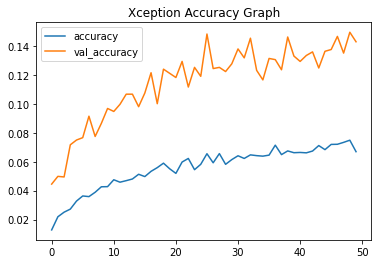

In [ ]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.title('Xception Accuracy Graph')

Text(0.5, 1.0, 'Xception Loss Graph')

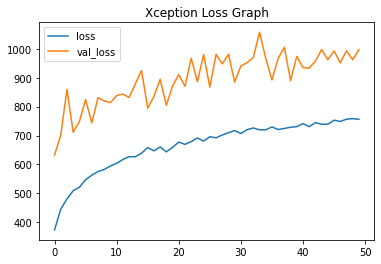

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.title('Xception Loss Graph')

In [ ]:
# Make prediction
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=-1)  

In [ ]:
df_test_new = pd.read_csv('/content/gdrive/MyDrive/Simcoe/894/Car dataset/df_test_new.csv')
feature_list = ['actual_class','predicted_class']
valid = pd.DataFrame(0, index=df_test_new.index, columns=feature_list)
valid['actual_class'] = df_test_new['class']
valid['predicted_class'] = y_pred+1

valid['diff'] = np.where(valid['actual_class'] == valid['predicted_class'],1,0)
accuracy = valid['diff'].sum()/valid.shape[0]*100
accuracy

3.955500618046971

## Tune Xception

In [ ]:
# img_size=224
base_model1 = Xception(weights='imagenet',include_top= False,input_shape=(img_size,img_size,3))
base_model1.trainable = False

In [ ]:
inputs = keras.layers.Input(shape=(img_size,img_size,3))
body = base_model1(inputs)
body = keras.layers.AvgPool2D(3)(body)
body = Flatten()(body)
body = Dropout(0.4)(body)
my_outputs = Dense(196,activation='softmax',kernel_regularizer='l2')(body)
model1 = keras.Model(inputs=inputs, outputs=my_outputs)

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss',
                         min_delta = 1.0e-5,
                         patience = 15,
                         verbose =2,
                         restore_best_weights = True)

checkpoint = ModelCheckpoint('./',
                            save_weights_only=True,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            verbose = 2
                            )

reduce_lr=ReduceLROnPlateau(monitor='val_accuracy',
                         factor=0.1,
                         patience=5,
                         verbose=2,
                         mode='auto',
                         min_delta=0.0001,
                         cooldown=0,
                         min_lr=0)

callbacks = [earlystop,checkpoint,reduce_lr]

In [ ]:
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

history1 = model1.fit(train_data,
                      epochs=50,
                      validation_data=val_data,
                      verbose=1,
                      callbacks=callbacks
                      )

model1.save('/content/gdrive/MyDrive/Simcoe/894/saved_models/Xception_lr0.5.hdf5')

Epoch 1/50
355/355 [==============================] - 178s 495ms/step - loss: 1129.5271 - accuracy: 0.0069 - val_loss: 1330.2438 - val_accuracy: 0.0086

Epoch 00001: val_loss improved from inf to 1330.24377, saving model to ./
Epoch 2/50
355/355 [==============================] - 173s 487ms/step - loss: 1183.8328 - accuracy: 0.0067 - val_loss: 1115.2056 - val_accuracy: 0.0091

Epoch 00002: val_loss improved from 1330.24377 to 1115.20557, saving model to ./
Epoch 3/50
355/355 [==============================] - 171s 483ms/step - loss: 1124.6822 - accuracy: 0.0077 - val_loss: 1528.7887 - val_accuracy: 0.0062

Epoch 00003: val_loss did not improve from 1115.20557
Epoch 4/50
355/355 [==============================] - 172s 485ms/step - loss: 1186.0235 - accuracy: 0.0068 - val_loss: 1797.8214 - val_accuracy: 0.0070

Epoch 00004: val_loss did not improve from 1115.20557
Epoch 5/50
355/355 [==============================] - 171s 481ms/step - loss: 1180.4017 - accuracy: 0.0072 - val_loss: 1367.1

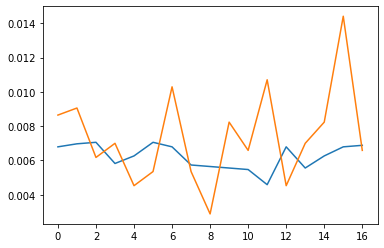

In [ ]:
plt.plot(history1.history['accuracy'],label='accuracy')
plt.plot(history1.history['val_accuracy'],label='val_accuracy')

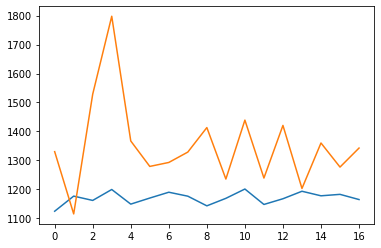

In [ ]:
plt.plot(history1.history['loss'],label='loss')
plt.plot(history1.history['val_loss'],label='val_loss')

In [ ]:
y_pred1 = model1.predict(test_data)
y_pred1 = np.argmax(y_pred1, axis=-1)  

In [ ]:
df_test_new1 = pd.read_csv('/content/gdrive/MyDrive/Simcoe/894/Car dataset/df_test_new.csv')
valid1 = pd.DataFrame(0, index=df_test_new1.index, columns=feature_list)
valid1['actual_class'] = df_test_new1['class']
valid1['predicted_class'] = y_pred1+1

valid1['diff'] = np.where(valid1['actual_class'] == valid1['predicted_class'],1,0)
accuracy1 = valid1['diff'].sum()/valid1.shape[0]*100
accuracy1

0.9476720230737536